In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [ ]:
from IPython.display import Audio

In [ ]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
DB_PATH = ".\Database\Marathi Database new"
Anger_path = "\Anger"
Happy_path = "\Happiness"
Sad_path = "\Sadness"
Fear_path = "\Fear"
Boredom_path = "\Boredom"
mood_path = [Anger_path, Happy_path, Sad_path, Fear_path, Boredom_path]
moods = ["anger","happy","sad","fear","boredom"]
emotion = []
file_path = []
for i, mood in enumerate(mood_path):
    for file in os.listdir(DB_PATH + mood):
        emotion.append(moods[i])
        file_path.append(DB_PATH + mood + "\\" + file)

In [ ]:
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)
data_path

,Emotions,Path
0,anger,.\Database\Marathi Database new\Anger\Fe1.A1.wav
1,anger,.\Database\Marathi Database new\Anger\Fe2A1.wav
2,anger,.\Database\Marathi Database new\Anger\Fe2A2.wav
3,anger,.\Database\Marathi Database new\Anger\Me1A1.wav
4,anger,.\Database\Marathi Database new\Anger\Me2A1.wav
...,...,...
76,boredom,.\Database\Marathi Database new\Boredom\Mel4B7...
77,boredom,.\Database\Marathi Database new\Boredom\Mel4B8...
78,boredom,.\Database\Marathi Database new\Boredom\SacB1.wav
79,boredom,.\Database\Marathi Database new\Boredom\SacB2.wav


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

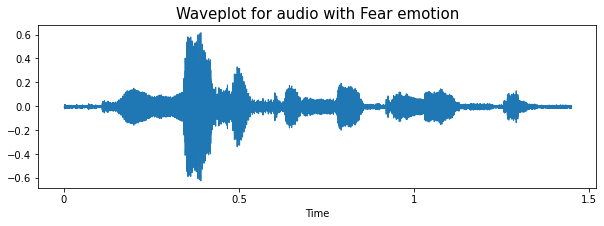

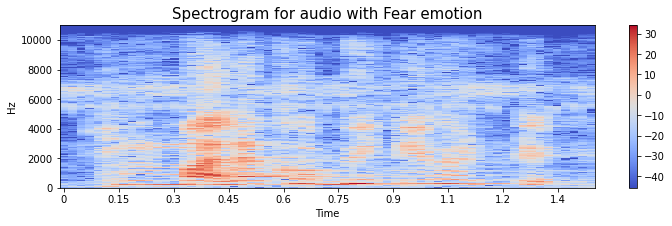

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, 'Fear')
create_spectrogram(data, sampling_rate, 'Fear')
Audio(path)

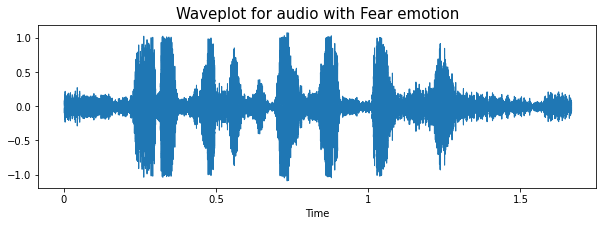

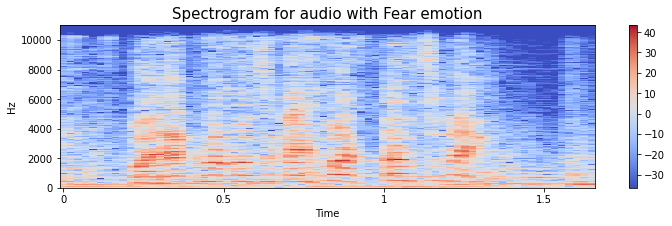

In [ ]:
emotion='anger'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, 'Fear')
create_spectrogram(data, sampling_rate, 'Fear')
Audio(path)

# Data augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


#### 1. Simple Audio

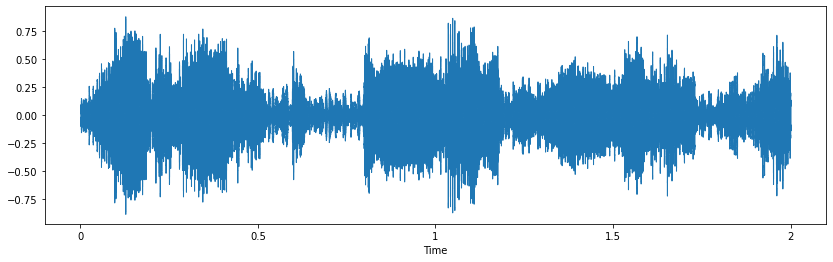

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

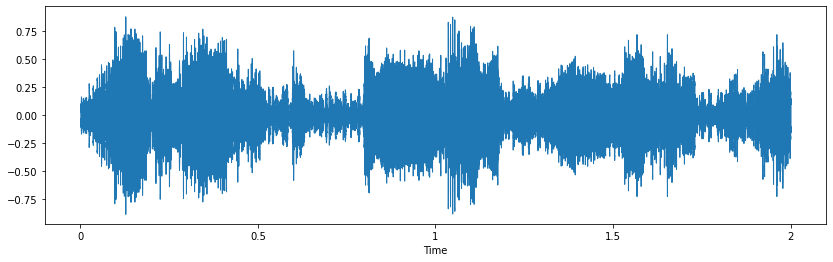

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

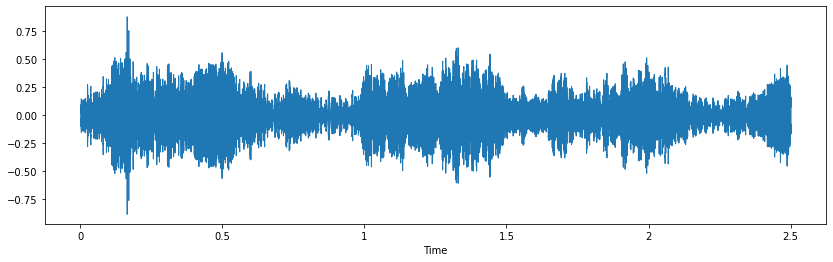

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### Feature Extraction

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.157489,0.422369,0.460731,0.572391,0.563652,0.512312,0.613389,0.542215,0.503547,0.479163,...,0.009711,0.011153,0.007903,0.018043,0.016077,0.011558,0.003190,0.000276,5.756788e-06,anger
1,0.201641,0.448210,0.470139,0.560790,0.606392,0.552651,0.619835,0.583866,0.512901,0.523367,...,0.027297,0.028599,0.030222,0.042252,0.037207,0.032775,0.022631,0.021915,2.165142e-02,anger
2,0.165305,0.370057,0.416880,0.463691,0.571299,0.520074,0.518410,0.654952,0.493840,0.466662,...,0.005834,0.004169,0.003093,0.002220,0.003251,0.002411,0.000932,0.000081,6.192419e-07,anger
3,0.106981,0.621932,0.646409,0.476234,0.428018,0.402539,0.347211,0.383183,0.480527,0.624734,...,0.032011,0.020918,0.013913,0.017345,0.021425,0.020643,0.012528,0.000878,6.567619e-06,anger
4,0.149679,0.641447,0.661144,0.510194,0.478246,0.462491,0.403861,0.423829,0.508098,0.644342,...,0.058426,0.043008,0.035720,0.038425,0.045009,0.042839,0.036028,0.024261,2.254514e-02,anger


### Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# multiclass classification so perform one-hot encoding 
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((182, 162), (182, 5), (61, 162), (61, 5))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((182, 162), (182, 5), (61, 162), (61, 5))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((182, 162, 1), (182, 5), (61, 162, 1), (61, 5))

### Modelling

In [ ]:
Features = pd.read_csv("./features.csv")

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 128)         

In [ ]:
checkpoint = ModelCheckpoint(r'D:\Akhilesh\Programs\Projects\Final year\Model\weight.h5', verbose=1, save_best_only=True)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/50
2/3 [===================>..........] - ETA: 0s - loss: 1.6535 - accuracy: 0.1875
Epoch 1: val_loss improved from inf to 1.42915, saving model to D:\Akhilesh\Programs\Projects\Final year\Model\weight.h5
3/3 [==============================] - 1s 430ms/step - loss: 1.6146 - accuracy: 0.2143 - val_loss: 1.4291 - val_accuracy: 0.2951
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 1.4469 - accuracy: 0.4375
Epoch 2: val_loss improved from 1.42915 to 1.31839, saving model to D:\Akhilesh\Programs\Projects\Final year\Model\weight.h5
3/3 [==============================] - 0s 118ms/step - loss: 1.4717 - accuracy: 0.4011 - val_loss: 1.3184 - val_accuracy: 0.4262
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 1.3169 - accuracy: 0.4219
Epoch 3: val_loss improved from 1.31839 to 1.22520, saving model to D:\Akhilesh\Programs\Projects\Final year\Model\weight.h5
3/3 [==============================] - 0s 134ms/step - loss: 1.3510 - accuracy: 0.4560 - val_lo

3/3 [==============================] - 0s 133ms/step - loss: 0.7169 - accuracy: 0.7198 - val_loss: 0.7873 - val_accuracy: 0.6557
Epoch 28/50
1/3 [=========>....................] - ETA: 0s - loss: 0.4629 - accuracy: 0.7969
Epoch 28: val_loss did not improve from 0.78727
3/3 [==============================] - 0s 24ms/step - loss: 0.6034 - accuracy: 0.7418 - val_loss: 0.8470 - val_accuracy: 0.6393
Epoch 29/50
1/3 [=========>....................] - ETA: 0s - loss: 0.6549 - accuracy: 0.7344
Epoch 29: val_loss did not improve from 0.78727
3/3 [==============================] - 0s 24ms/step - loss: 0.6695 - accuracy: 0.7143 - val_loss: 0.9286 - val_accuracy: 0.6885
Epoch 30/50
1/3 [=========>....................] - ETA: 0s - loss: 0.6527 - accuracy: 0.7500
Epoch 30: val_loss did not improve from 0.78727
3/3 [==============================] - 0s 23ms/step - loss: 0.6541 - accuracy: 0.7088 - val_loss: 0.7904 - val_accuracy: 0.6393
Epoch 31/50
1/3 [=========>....................] - ETA: 0s - los

2/2 [==============================] - 0s 96ms/step - loss: 0.5485 - accuracy: 0.8033
Accuracy of our model on test data :  80.32786846160889 %


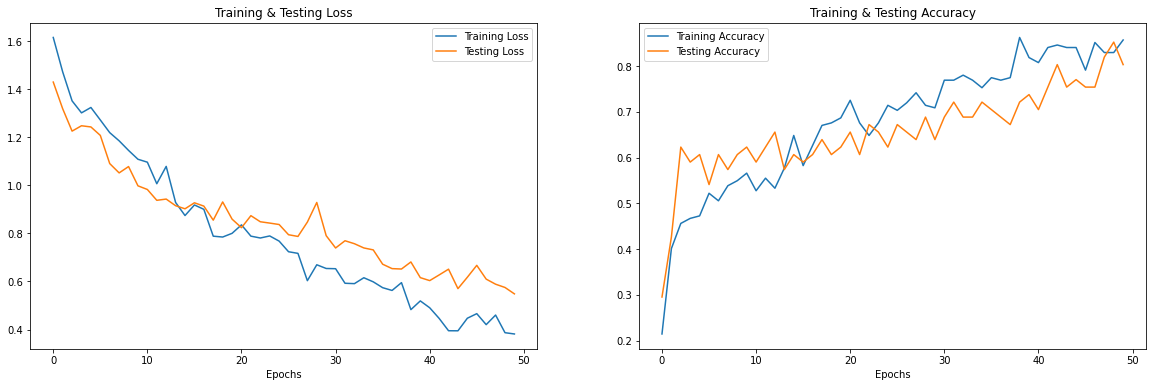

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,sad,sad
2,anger,anger
3,anger,happy
4,sad,sad
5,sad,happy
6,sad,sad
7,happy,happy
8,sad,sad
9,boredom,boredom


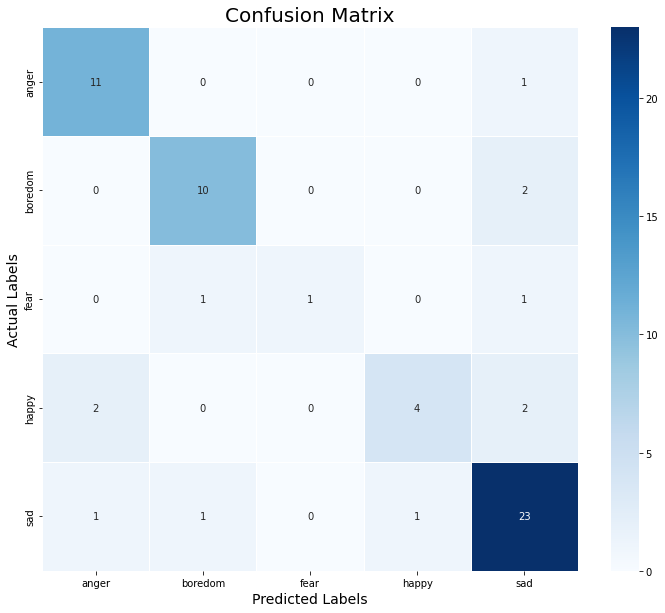

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.79      0.92      0.85        12
     boredom       0.83      0.83      0.83        12
        fear       1.00      0.33      0.50         3
       happy       0.80      0.50      0.62         8
         sad       0.79      0.88      0.84        26

    accuracy                           0.80        61
   macro avg       0.84      0.69      0.73        61
weighted avg       0.81      0.80      0.79        61

